In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from scipy.stats import multivariate_normal
from scipy.misc import logsumexp

Here, I'm defining the event segmentation model and a linear dymanic system that is used as the event model. See SEM project notes for details, but it's what's proposed


In [2]:
class LinearDynamicSystem(object):

    def __init__(self, D, eta=0.01):
        """
        Parameters
        ----------
        D: int
            dimensions of the vector space of interest
            
        eta: float
            learning rate
        """
        
        self.beta = np.zeros(D).flatten()
        self.W = np.eye(D).flatten()
        self.eta = eta
        
    def predict(self, X):
        """
        Parameters
        ----------
        X: np.array of length D
            vector at time t
        
        Returns
        -------
        Xp_hat: np.array of length D
            prediction of vector at time t+1
            
        g:
            used for training
        
        """
        D = np.shape(X)[0]
        Xp_hat = self.beta + np.matmul(X, np.reshape(self.W , (D, D)))

        dXdb = np.eye(D)
        dXdW = np.tile((np.tile(X, (1, D))), (D, 1))
        g = np.concatenate([dXdb, dXdW], axis=1)
        return Xp_hat, g
    
    def update(self, X, X_hat, g):
        """
        Parameters
        ----------
        
        Xp: np.array of length D
            observed vector
            
        Xp_hat:  np.array of length D
            predicted vector
            
        g: 
            used for training
            
        """
        
        # vectorize the parameters
        theta = np.concatenate([self.beta, self.W.flatten()])
        theta += self.eta * np.matmul(X - X_hat, g)
        
        # store the updated parameters
        self.beta = theta[:np.shape(X)[0]]
        self.W = theta[np.shape(X)[0]:]
        
    
class SEM(object):
    """
    This port of SAM's code (done with a different programming logic)
    in python. More documation to come!
    """
    
    def __init__(self, lmda=1., alfa=10.0, beta=0.1, f_class=None, f_opts=None):
        """
        Parameters
        ----------
        
        lmbda: float
            sCRP stickyness parameter
        
        alfa: float
            sCRP concentration parameter
        
        beta: float
            gaussian noise parameter
            
        f_class: class
            object class that has the functions "predict" and "update".
            used as the event model
            
        f_opts: dictionary
            kwargs for initializing f_class
        """
        self.lmda = lmda
        self.alfa = alfa
        self.beta = beta
        
        if f_class is None:
            self.f_class = LinearDynamicSystem
        else:
            self.f_class = f_class
        if f_opts is None:
            self.f_opts = {'eta': 0.01}
        else:
            self.f_opts = f_opts

            
    def run(self, X, K=None):
        """
        Parameters
        ----------
        X: N x D array of 
        
        K: int
            maximum number of clusters
        
        Return
        ------
        post: N by K array of posterior probabilites
        """
        
        [N, D] = np.shape(X)
        
        Sigma = np.eye(D) * self.beta  # noise for multivariate gaussian likelihood

        if K is None:
            K = N
        
        C = np.zeros(K)  # running count of the clustering process
        prior = C.copy()
        
        event_models = dict()  # initialize an empty event model space
        
        x_prev = np.zeros(D)  # need a starting location as is sequential model
        post = np.zeros((N, K))
        
        for n in range(N):
            # calculate sCRP prior
            prior = C.copy()
            idx =  len(np.nonzero(C)[0])  # get number of visited clusters
            
            if idx < K:
                prior[idx] = self.alfa  # set new cluster probability to alpha

            # add stickyness parameter for n>0
            if n > 0: 
                prior[np.argmax(post[n, :])] + self.lmda 

            prior /= np.sum(prior)
            
            # likelihood
            active = np.nonzero(prior)[0]
            lik = np.zeros(len(active))
            X_hat = np.zeros((len(active), D)) # store the predictions for updating
            g = dict()
            for k in active:
                if k not in event_models.keys():
                    event_models[k] = self.f_class(D, **self.f_opts)
                
                model = event_models[k]
                X_hat[k, :], g[k] = model.predict(x_prev)
                
                
                lik[k] = multivariate_normal.pdf(X[n, :] - X_hat[k, :], mean=np.zeros(D), cov=Sigma)
                
            # posterior
            p = np.log(prior[:len(active)]) + np.log(lik)
            post[n, :len(active)] = np.exp(p - logsumexp(p))

            # update 
            k = np.argmax(post[n, :]) # MAP cluster
            C[k] += 1 # update counts
            event_models[k].update(X[n, :], X_hat[k, :], g[k])
            
            x_prev = X[0, :].copy()  # store the current vector for next trial
        
        return post

Now, we define some toy problem

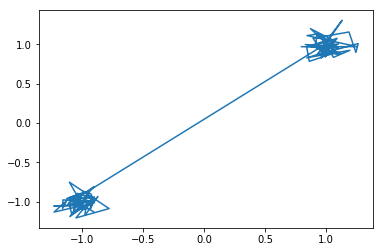

In [3]:
# first demo -- gaussian mixture defined by the CRP

def build_static_dataset(N, beta=0.1):
    """ 
    2 events, modeled as gaussians with different means
    """
    
    pi = np.array([0.4, 0.6])
    mus = [[1, 1], [-1, -1]]
    stds = np.ones((2, 2)) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N/2):
        x[n, :] = np.random.multivariate_normal(mus[0], np.diag(stds[0]))
    for n in range(N/2, N):
        x[n, :] = np.random.multivariate_normal(mus[1], np.diag(stds[1]))
        
    return x

x_train = build_static_dataset(100, 0.01)
plt.plot(x_train[:, 0], x_train[:, 1])

In [4]:
K = 20  # maximum number of event types
lmda = 1  # stickyness parameter
alfa = 10.0  # concentration parameter
beta = 0.01 # transition noise
eta =  0.1  # learning rate

sem_kwargs = dict(lmda=lmda, alfa=alfa, beta=beta, 
                  f_class=LinearDynamicSystem, f_opts=dict(eta=eta))

sem = SEM(**sem_kwargs)
post = sem.run(x_train, K=K)

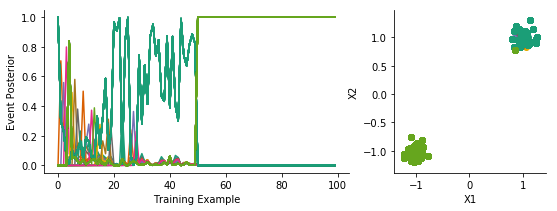

In [5]:
def plot_segmentation(post):
    fig, axes = plt.subplots(1, 2, figsize=(9, 3), gridspec_kw={'width_ratios':[2, 1]})
    cluster_id = np.argmax(post, axis=1)
    import seaborn as sns
    cc = sns.color_palette('Dark2', post.shape[1])
    for clt in cluster_id:
        idx = np.nonzero(cluster_id == clt)[0]
        plt.scatter(x_train[idx, 0], x_train[idx, 1], color=cc[clt])
    axes[1].set_xlabel('X1')
    axes[1].set_ylabel('X2')

    for clt in cluster_id:
        axes[0].plot(post[:, clt], color=cc[clt])
        
    axes[0].set_xlabel('Training Example')
    axes[0].set_ylabel('Event Posterior')
    
    sns.despine()
    
plot_segmentation(post)

In [6]:
# np.max(post, axis=1)
post.shape

(100, 20)

In [7]:
#show the envent number that was chosen
np.argmax(post, axis=1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9,  0, 10, 11, 12,  0, 13,  0,
        0, 14, 15,  0,  0,  0, 16,  0,  0, 17, 18, 19,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4])

Now, alternative between two events


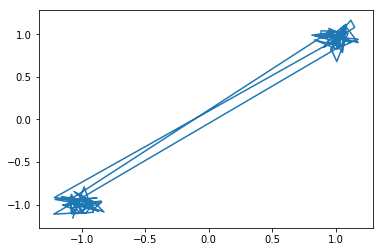

In [8]:
def build_alternating_static_events(N, beta=0.1):
    """ 
    2 alternating events, modeled as gaussians with different means
    """
    
    pi = np.array([0.4, 0.6])
    mus = [[1, 1], [-1, -1]]
    stds = np.ones((2, 2)) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    for n in range(N/4):
        x[n, :] = np.random.multivariate_normal(mus[0], np.diag(stds[0]))
    for n in range(N/4, N/2):
        x[n, :] = np.random.multivariate_normal(mus[1], np.diag(stds[1]))
    for n in range(N/2, N/4*3):
        x[n, :] = np.random.multivariate_normal(mus[0], np.diag(stds[0]))
    for n in range(N/4*3, N):
        x[n, :] = np.random.multivariate_normal(mus[1], np.diag(stds[1]))
        
    return x

x_train = build_alternating_static_events(100, 0.01)
plt.plot(x_train[:, 0], x_train[:, 1])

In [9]:
post = sem.run(x_train, K=K)

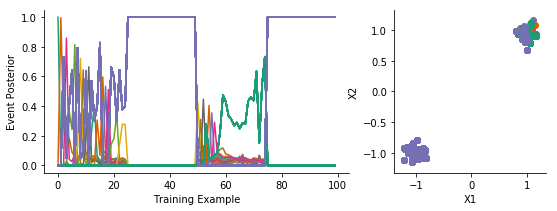

In [10]:
plot_segmentation(post)

In [11]:
#show the envent number that was chosen. Notice the re-use of events
np.argmax(post, axis=1)

array([ 0,  1,  2,  3,  2,  2,  4,  2,  5,  6,  2,  7,  2,  8,  2,  2,  9,
       10, 11,  2,  2, 12,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2, 13,
       14, 15, 16, 17, 18, 19, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2])

Below an example of two events where the events correspond to movement in vector space

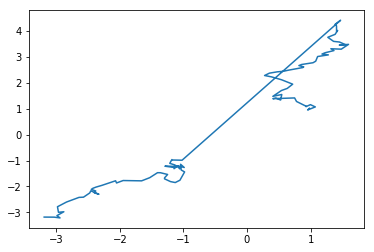

In [12]:

def build_moving_data(N, beta=0.01):
    pi = np.array([0.4, 0.6])
    bs = [[1, 1], [-1, -1]]  # starting point!
    ws = [np.array([[1, 0], [.5, 2]]), np.array([[-1, .2], [-.2, 1]])]
    stds = np.eye(2) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    
    x[0, :] = np.random.multivariate_normal(bs[0], stds)
    for n in range(1, N/2):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, stds)
        
    x[N/2, :] = np.random.multivariate_normal(bs[1], stds)
    for n in range(N/2+1, N):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, stds)
    return x

x_train = build_moving_data(100)
plt.plot(x_train[:, 0], x_train[:, 1])

In [13]:
post = sem.run(x_train, K=K)

/Users/nickfranklin/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:167: RuntimeWarning: divide by zero encountered in log


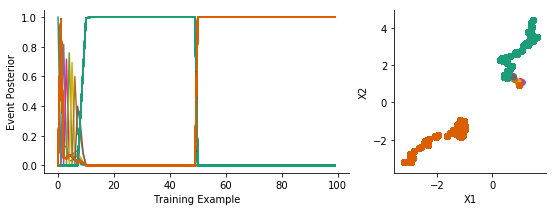

In [14]:
plot_segmentation(post)

In [15]:
np.argmax(post, axis=1)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1])

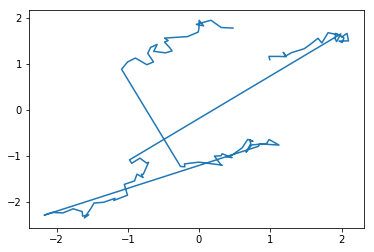

In [16]:

def build_alternating_moving_events(N, beta=0.01):
    pi = np.array([0.4, 0.6])
    bs = [[1, 1], [-1, -1], [1, -1], [-1, 1]]  # starting point!
    ws = [np.array([[1, 0], [.5, 2]]), np.array([[-1, .2], [-.2, 1]])]
    Sigma = np.eye(2) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    
    x[0, :] = np.random.multivariate_normal(bs[0], Sigma)
    for n in range(1, N/4):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
        
    x[N/4, :] = np.random.multivariate_normal(bs[1], Sigma)
    for n in range(N/4+1, N/2):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
            
    x[N/2, :] = np.random.multivariate_normal(bs[2], Sigma)
    for n in range(N/2+1, N/4*3):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
        
    x[N/4*3, :] = np.random.multivariate_normal(bs[3], Sigma)
    for n in range(N/4*3+1, N):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)      
        
    return x

x_train = build_alternating_moving_events(100)
plt.plot(x_train[:, 0], x_train[:, 1])

In [17]:
post = sem.run(x_train, K=K)

/Users/nickfranklin/anaconda/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:167: RuntimeWarning: divide by zero encountered in log


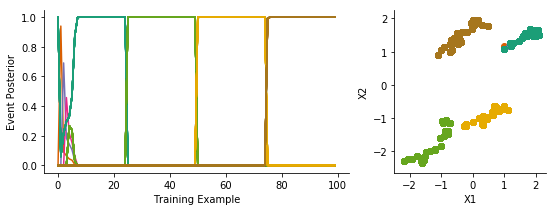

In [18]:
plot_segmentation(post)

In [19]:
np.argmax(post, axis=1)

array([0, 1, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6])

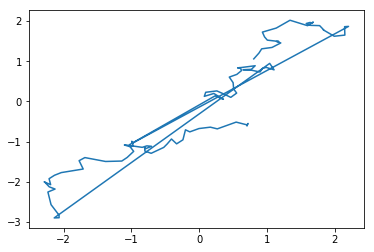

In [20]:

def build_alternating_moving_events(N, beta=0.01):
    pi = np.array([0.4, 0.6])
    bs = [[1, 1], [-1, -1], [1, -1], [-1, 1]]  # starting point!
    ws = [np.array([[1, 0], [.5, 2]]), np.array([[-1, .2], [-.2, 1]])]
    Sigma = np.eye(2) * beta
    x = np.zeros((N, 2), dtype=np.float32)
    
    x[0, :] = np.random.multivariate_normal(bs[0], Sigma)
    for n in range(1, N/4):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
        
    x[N/4, :] = np.random.multivariate_normal(bs[1], Sigma)
    for n in range(N/4+1, N/2):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
            
    x[N/2, :] = np.random.multivariate_normal(bs[0], Sigma)
    for n in range(N/2+1, N/4*3):
        _x = x[n-1, :] + np.array([-0.05, -0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)
        
    x[N/4*3, :] = np.random.multivariate_normal(bs[1], Sigma)
    for n in range(N/4*3+1, N):
        _x = x[n-1, :] + np.array([0.05, 0.05])
        x[n, :] = np.random.multivariate_normal(_x, Sigma)      
        
    return x

x_train = build_alternating_moving_events(100)
plt.plot(x_train[:, 0], x_train[:, 1])

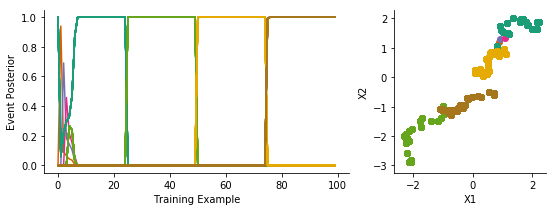

In [21]:
plot_segmentation(post)